In [1]:
from tqdm import tqdm
import pickle
import gzip
from typing import List
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder

from neural_network.layers.base_layer import BaseLayer
from neural_network.layers.linear_layer import LinearLayer
from neural_network.layers.relu_layer import ReluLayer
from neural_network.layers.sigmoid_layer import SigmoidLayer
from neural_network.models.layer_types import LayerTypes
from neural_network.utils import predict, accuracy

from neural_network.losses.squared_loss import SquaredLoss
from neural_network.losses.absolute_loss import AbsoluteLoss

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# set the seed to zero for reproducibility
np.random.seed(0)

In [3]:
# input
input_size = 64
# output
output_size = 64

# number of samples (datapoints)
N_TRAIN = 1_000
N_TEST = 10

In [4]:
digits = load_digits()

x_train, x_test = train_test_split(digits.data, test_size=0.1)

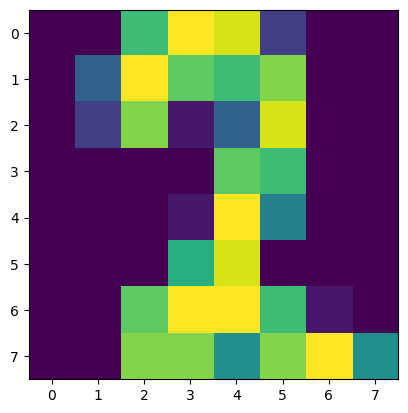

In [5]:
plt.imshow(np.reshape(x_test[0], newshape=(8, 8)))

In [6]:
min_vals = np.min(x_train)
max_vals = np.max(x_train)

x_train = (x_train - min_vals) / (max_vals - min_vals)

y_train = x_train.copy()

x_test = (x_test - min_vals) / (max_vals - min_vals)

y_test = x_test.copy()

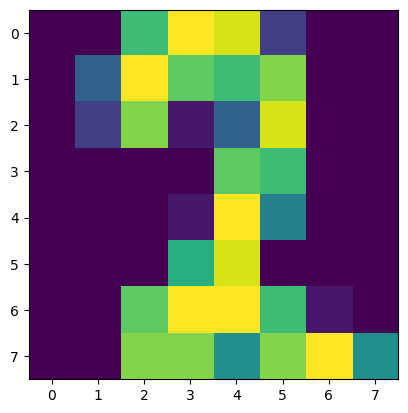

In [7]:
plt.imshow(np.reshape(x_test[0], newshape=(8, 8)))

In [8]:
shuffle_ix = np.arange(0, N_TRAIN, 1) 
np.random.shuffle(shuffle_ix,)

In [9]:
SAVE = True

BATCH_SIZE = 8
LEARNING_RATE = 1e-3
EPOCHS = 30

# neural network: nothing but a list of layers!
neural_net: List[BaseLayer] = [
    LinearLayer(input_size=input_size, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=3),
    ReluLayer(),
    LinearLayer(input_size=3, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=output_size),
    SigmoidLayer(),
]

# loss = AbsoluteLoss()
loss = SquaredLoss()

In [10]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for batch_start in range(0, N_TRAIN, BATCH_SIZE):
        batch_ix = shuffle_ix[batch_start: batch_start + BATCH_SIZE]

        X_batch: np.ndarray = x_train[batch_ix]
        y_batch: np.ndarray = y_train[batch_ix]

        # transpose, (m x N) and (n x N)
        X_batch = X_batch.T
        y_batch = y_batch.T

        ### forward propagation
        fps = []
        fp = X_batch
        for layer in neural_net:
            fp = layer.forward(fp, persist=True)
            fps.append(fp)

        train_loss = loss.forward(Yhat=fp, Y=y_batch)
        epoch_loss.append(train_loss)
        
        # final upstream grads
        # should ideally come from the loss function, assume it for now 
        # (this will change when the loss function is implemented)
        # dLdY = np.random.randn(y_batch.shape[0], y_batch.shape[1])

        # compute the final upstream grads from the loss function
        dLdY = loss.backward(Yhat=fp, Y=y_batch)

        ### backprop
        # iterate the layers in reversed order for backprop, use chain rule recursively!
        for layer in reversed(neural_net):
            if layer.type == LayerTypes.ACTIVATION:
                dLdY = layer.backward(dLdY=dLdY)

            if layer.type == LayerTypes.LINEAR:
                # use these for gradient update
                dLdW, dLdb = layer.grads(dLdY=dLdY)

                ### gradient descent
                layer.weights -= LEARNING_RATE * dLdW
                layer.bias -= LEARNING_RATE * dLdb

                # new dLdY to pass to the previous layer
                dLdY = layer.backward(dLdY=dLdY)
    
    train_losses.append(np.mean(epoch_loss))
    # train_accuracies.append(accuracy(neural_net=neural_net, X_data=X_train, y_data=y_train))
    # test_accuracies.append(accuracy(neural_net=neural_net, X_data=X_test, y_data=y_test))


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 102.68it/s]


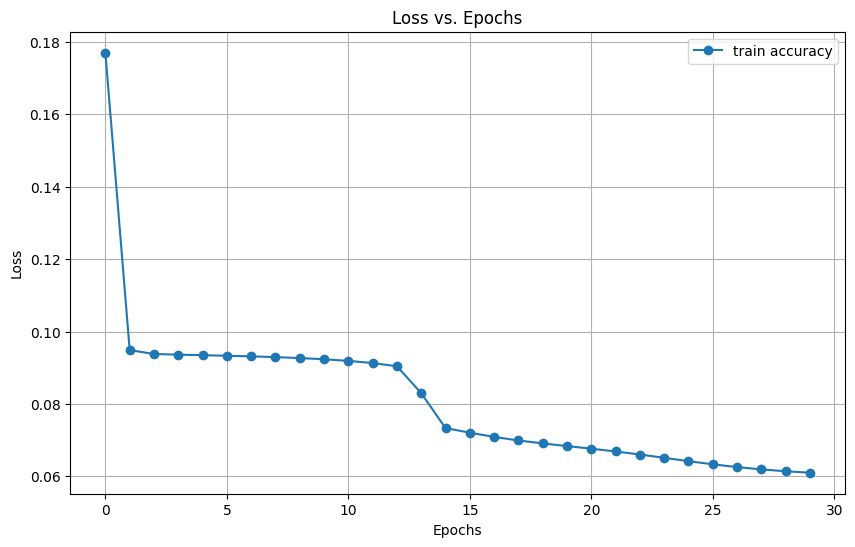

In [11]:
# plot the train and test accuracies
plt.figure(figsize=(10, 6)) 
plt.plot(range(EPOCHS), train_losses, marker='o', linestyle='-',label='train accuracy')
# plt.plot(range(EPOCHS), test_accuracies, marker='s', linestyle='--', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
y_test_pred = predict(neural_net, x_test)

0.05586173013504605


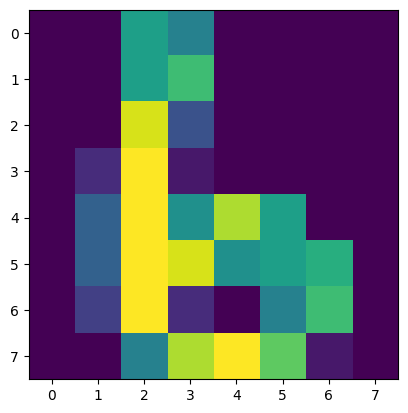

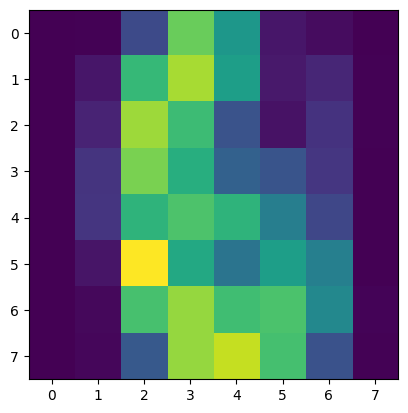

In [22]:
r_ix = 3

print(np.mean(np.square((x_test[r_ix] - y_test_pred[r_ix]))))

plt.figure()
plt.imshow(np.reshape(y_test[r_ix], newshape=(8, 8)))
plt.figure()
plt.imshow(np.reshape(y_test_pred[r_ix], newshape=(8, 8)))

In [14]:
tf_neural_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_size)),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=3, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=output_size, activation="sigmoid"),
])

# tf_neural_net.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LEARNING_RATE), loss="mse")
tf_neural_net.compile(optimizer="adam", loss="mse")

tf_neural_net.summary()

2023-11-09 21:26:59.307542: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-09 21:26:59.307567: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-09 21:26:59.307575: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-09 21:26:59.307606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-09 21:26:59.307620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 64)                704       
                                                                 
Total params: 1427 (5.57 KB)
Trainable params: 1427 (5.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = tf_neural_net.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/30


2023-11-09 21:26:59.718728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 2s 8ms/step - loss: 0.1039
Epoch 2/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0688
Epoch 3/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0612
Epoch 4/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0566
Epoch 5/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0544
Epoch 6/30
203/203 [==============================] - 1s 7ms/step - loss: 0.0536
Epoch 7/30
203/203 [==============================] - 1s 7ms/step - loss: 0.0533
Epoch 8/30
203/203 [==============================] - 1s 7ms/step - loss: 0.0527
Epoch 9/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0520
Epoch 10/30
203/203 [==============================] - 1s 6ms/step - loss: 0.0513
Epoch 11/30
203/203 [==============================] - 1s 7ms/step - loss: 0.0511
Epoch 12/30
203/203 [==============================] - 1s 7ms/step - loss: 0.0503
Epoch 13/30
203/203 [===============

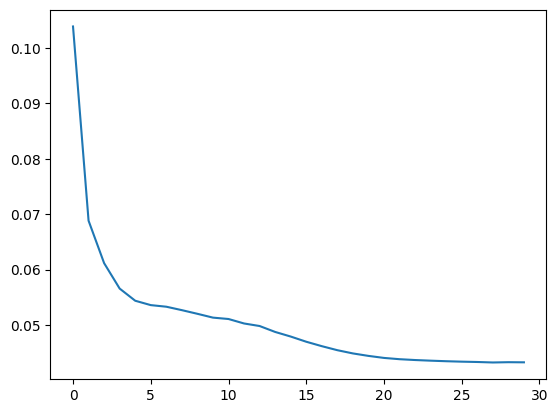

In [16]:
plt.figure()
plt.plot(history.history["loss"])

In [17]:
y_test_pred_tf = tf_neural_net.predict(x_test)

6/6 [==============================] - 0s 5ms/step


0.04738279545316158


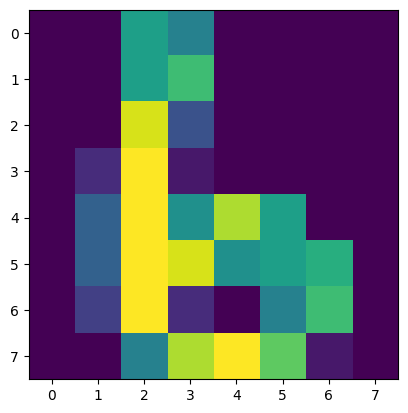

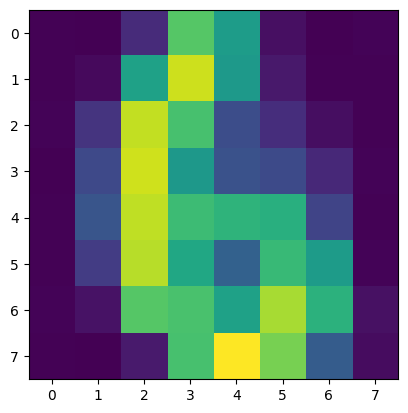

In [23]:
# mse = tf.keras.losses.MeanSquaredError()

print(np.mean(np.square(x_test[r_ix] - y_test_pred_tf[r_ix])))
# print(mse(y_test[0], y_test_pred_tf[0]))

plt.figure()
plt.imshow(np.reshape(y_test[r_ix], newshape=(8, 8)))
plt.figure()
plt.imshow(np.reshape(y_test_pred_tf[r_ix], newshape=(8, 8)))